# **Maestr√≠a en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnol√≥gico de Monterrey

### Prof Luis Eduardo Falc√≥n Morales

## Adtividad Semana 6 y 7

### **Topic modeling**

#### **Nombres y matr√≠culas de los integrantes del equipo:**



*   Elemento de lista
*   Elemento de lista



### En la actividad de esta semana trabajar√°s en equipos en el tema de modelado de temas (topic modeling).

In [63]:
import json
import pandas as pd 
import seaborn as sns
import nltk
import re

from nltk.stem import WordNetLemmatizer
from nltk.stem import RegexpStemmer
from nltk.corpus import stopwords
from nltk.corpus import swadesh
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import warnings

import matplotlib.pyplot as plt

##**Pregunta - 1:**



Descarga el archivo noticiasTopicModeling.txt que se encuentra en Canvas. Este archivo consiste en 5658 noticias de varios peri√≥dicos de Espa√±a. El archivo de texto es una lista en el siguiente formato:

[{‚Äútitular‚Äù:‚ÄùEncabezado‚Äú, ‚Äútexto‚Äù:‚ÄùCuerpo‚Äù}, ‚Ä¶ , {‚Äútitular‚Äù:‚ÄùEncabezado‚Äù,‚Äùtexto‚Äù:‚ÄùCuerpo‚Äù}]

Donde ‚Äú*titular*‚Äù es el encabezado de la noticia y ‚Äútexto‚Äù es el cuerpo del texto de dicha noticia. En
particular en esta actividad trabajar√°s solamente con los cuerpos de las noticias, sin incluir los
encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado ‚Äúdf‚Äù y que contiene
una √∫nica columna llamada ‚Äúnoticia‚Äù con 5658 renglones formados por los cuerpos de las noticias.

In [22]:
# Lectura de acrchivo noticiasTopicModeling

with open('noticiasTopicModeling.txt') as f:
    json_data = json.load(f)

df = pd.json_normalize(json_data)
df = df['texto'].to_frame()
df.columns = [col.replace('texto', 'noticia').title() for col in df.columns]

In [23]:
df.shape

(5658, 1)

In [24]:
# Verifiquemos la informaci√≥n del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5658 entries, 0 to 5657
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Noticia  5658 non-null   object
dtypes: object(1)
memory usage: 44.3+ KB


In [25]:
df.head()

Noticia
0  "Espa√±a ha dejado de ser cat√≥lica", dec√≠a Manu...
1  El clima de crispaci√≥n social en Ceuta ha lleg...
2  El Gobierno ha alegado la suspensi√≥n de plazos...
3  Puedes mandar tu pregunta, sugerencia o queja¬†...
4  Panam√° debe entregar esta semana a la Corte In...

##**Pregunta - 2:**

Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en espa√±ol. Recuerda que el objetivo es identificar los tokens (palabras) que describan mejor la distribuci√≥n de cada tema.

#### NOTA: Recuerda que esta es una t√©cnica no supervisada, por lo que no requerimos hacer una partici√≥n de los datos.










In [65]:
nltk.download('punkt') 
nltk.download('stopwords')
wnl = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ingsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ingsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
mystopwords = stopwords.words('spanish') # Generamos el arreglo para las stop words

print("N√∫mero de stopwords: ",len(mystopwords))
print(mystopwords)

N√∫mero de stopwords:  313
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'm√°s', 'pero', 'sus', 'le', 'ya', 'o', 'este', 's√≠', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'tambi√©n', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'm√≠', 'antes', 'algunos', 'qu√©', 'unos', 'yo', 'otro', 'otras', 'otra', '√©l', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 't√∫', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'm√≠o', 'm√≠a', 'm√≠os', 'm√≠as', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'est√°s', '

In [28]:
# Palabras incorrectas detectadas
wrong_words = ['aaa', 'aahjko', 'aaim', 'aalla', 'aai√∫n', 'aamir', 'aamma', 'aaon', 'aapp']

In [30]:
def clean_tok(doc):
    Xwords = re.sub(r'[^a-zA-Z√°√©√≠√≥√∫√º√±√Å√â√ç√ì√ö√ú√ë]', ' ', doc)
    Xtoks = [Xwords.lower().split()]
    XcleanTok = [[t for t in x if t not in mystopwords 
                                  and t not in wrong_words 
                                  and len(t) > 3 
                                  and len(t) < 20] 
                     for x in Xtoks]
    token = [t for x in XcleanTok for t in x]
    token_final = [wnl.lemmatize(w) for w in token]
    return token_final

In [31]:
# Aplicamos el proceso de limpieza y tokenizaci√≥n:

Xclean = [clean_tok(x) for x in df.Noticia] 

In [39]:
# Despleguemos los primeros comentarios despu√©s de tu proceso de limpieza:

for x in Xclean[0:10]: 
  print(x)

['espa√±a', 'dejado', 'cat√≥lica', 'dec√≠a', 'manuel', 'aza√±a', 'comienzo', 'segunda', 'rep√∫blica', 'aquel', 'congreso', 'diputados', 'aprob√≥', 'leyes', 'laicistas', 'met√°fora', 'dej√≥', 'cat√≥lica', 'papel', 'creencias', 'buena', 'parte', 'pueblo', 'migraci√≥n', 'integraci√≥n', 'europea', 'programa', 'europa', 'saber', 'espa√±a', 'domingo', 'noviembre', 'dejado', 'excepci√≥n', 'europa', 'potencia', 'extremum', 'derecha', 'parlamento', 'met√°fora', 'pues', 'precisamente', 'excepcional', 'tener', 'dictadura', 'mediados', 'setenta', 'dictador', 'mausoleo', 'despu√©s', 'a√±os', 'muerto', 'exist√≠a', 'cosa', 'portugal', 'grecia', 'italia', 'alemania', 'pa√≠ses', 'dictaduras', 'fascista', 'espa√±a', 'pas√≥', 'portugal', 'italia', 'alemania', 'derrot√≥', 'fascismo', 'franquismo', 'muri√≥', 'cama', 'harakiri', 'cortes', 'franquistas', 'ruptura', 'r√©gimen', 'sino', 'reforma', 'naci√≥', 'nuevo', 'pa√≠s', 'sino', 'pa√≠s', 'mut√≥', 'espa√±a', 'parec√≠a', 'vacunada', 'a√±os', 'franquismo', 's

In [40]:
ws_tok=[]  # inicializamos listas de los tokens

for x in Xclean:   
    ws_tok.extend(x)   # tokens usados en comentarios positivos

wc = ' '.join(ws_tok)   # requerimos un solo string por cada clase para la nube de palabras.

print('String de los comentarios/tokens:\n', wc[0:100])

String de los comentarios/tokens:
 espa√±a dejado cat√≥lica dec√≠a manuel aza√±a comienzo segunda rep√∫blica aquel congreso diputados aprob√≥


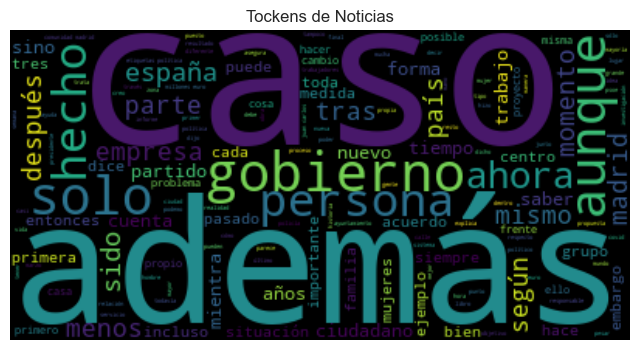

In [232]:
fig, (ax1) = plt.subplots(1, figsize=(8,8))

# Nube de palabras:
wordcloudnn = WordCloud().generate(wc)
ax1.imshow(wordcloudnn, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Tockens de Noticias')

plt.show()

## Parte 1: Indexaci√≥n sem√°ntica latente (LSI)

#**Pregunta - 3:**


Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens.

In [25]:
# Conjuntamos los documentos de nuevo en una lista de strings,
# que viene a ser nuestra document-term-matrix, DTM:

ddf = []

for doc in Xclean:
    tmp = ' '.join(doc)
    ddf.append(tmp)
    
ddf[0]

'espa√±a dejado cat√≥lica dec√≠a manuel aza√±a comienzo segunda rep√∫blica aquel congreso diputados aprob√≥ leyes laicistas met√°fora dej√≥ cat√≥lica papel creencias buena parte pueblo migraci√≥n integraci√≥n europea programa europa saber espa√±a domingo noviembre dejado excepci√≥n europa potencia extremum derecha parlamento met√°fora pues precisamente excepcional tener dictadura mediados setenta dictador mausoleo despu√©s a√±os muerto exist√≠a cosa portugal grecia italia alemania pa√≠ses dictaduras fascista espa√±a pas√≥ portugal italia alemania derrot√≥ fascismo franquismo muri√≥ cama harakiri cortes franquistas ruptura r√©gimen sino reforma naci√≥ nuevo pa√≠s sino pa√≠s mut√≥ espa√±a parec√≠a vacunada a√±os franquismo sido bastantes llegado irrupci√≥n posfranquismo tras actores fundamentales gobiernos auton√≥micos locale ciudadanos espa√±a dejado excepci√≥n aunque alianza popular manuel fraga bebiera franquismo sociol√≥gico fuerza nueva blas pi√±ar b√∫nker franquista aunque franquis

### Matriz Tf-idf

In [26]:
tfidf = TfidfVectorizer(max_df=1.0,  # (float o int) ignora las palabras con frecuencia mayor a max_df
                        min_df=1     # ignora las palabras con frecuencia menor a min_df
                       )

tfidf_sparse = tfidf.fit_transform(ddf)     # csr_matrix de la DTM

In [27]:
tfidf_dense = pd.DataFrame(tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out()) 
tfidf_dense.head(5)

aaa  aardman  aaron  aarron  aarts  aar√≥n  abad  abades  abadeses  abadi  \
0  0.0      0.0    0.0     0.0    0.0    0.0   0.0     0.0       0.0    0.0   
1  0.0      0.0    0.0     0.0    0.0    0.0   0.0     0.0       0.0    0.0   
2  0.0      0.0    0.0     0.0    0.0    0.0   0.0     0.0       0.0    0.0   
3  0.0      0.0    0.0     0.0    0.0    0.0   0.0     0.0       0.0    0.0   
4  0.0      0.0    0.0     0.0    0.0    0.0   0.0     0.0       0.0    0.0   

   ...  √∫nicas  √∫nico  √∫nicos  √∫riz  √∫rsula  √∫tero  √∫til  √∫tiles  √∫tlimo  \
0  ...     0.0    0.0     0.0   0.0     0.0    0.0   0.0     0.0     0.0   
1  ...     0.0    0.0     0.0   0.0     0.0    0.0   0.0     0.0     0.0   
2  ...     0.0    0.0     0.0   0.0     0.0    0.0   0.0     0.0     0.0   
3  ...     0.0    0.0     0.0   0.0     0.0    0.0   0.0     0.0     0.0   
4  ...     0.0    0.0     0.0   0.0     0.0    0.0   0.0     0.0     0.0   

   √ºnsal  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  

[5 rows x 96792 columns]

#### ¬øCu√°l es el significado de cada rengl√≥n?

Una Matriz Tf.idf es una representaci√≥n num√©rica de textos, donde cada una de las filas (rengl√≥n) representa un documento dentro de nuestro corpus.

#### ¬øY el significado de cada columna?

Para el caso de las columnas dentro de la matriz, representa un t√©rmino (palabra) dentro de nuestro corpus.

In [28]:
del tfidf_dense

#**Pregunta - 4:**

Aplica el m√©todo de descomposici√≥n de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gr√°fico de la importancia relativa de estas.

### Factorizaci√≥n SVD

In [29]:
# Se define el objeto que aplicar√° SVD truncada con r valores singulares:

r = 10    # M√°xima cantidad de valores singulares a considerar --> t√≥picos a generar:

lsi_obj = TruncatedSVD(n_components = r, 
                       n_iter=100,  # n√∫mero de iteraciones ... recordemos que es un m√©todo iterativo.
                       random_state=42) 

tfidf_lsi = lsi_obj.fit_transform(tfidf_sparse)    # ndarray: se ajusta y aplica la SVD truncada.

Sigma = lsi_obj.singular_values_    # ndarray_(r,)

V_T = lsi_obj.components_.T         # ndarray_(n_terms X r)  
                                    # Las r columnas son los r temas/topics generados
                                    # Se ordenan los n_terms/words de mayor a menor para 
                                    # obtener las keywords principales de cada t√≥pico.

In [30]:
sigmas = lsi_obj.singular_values_

sigmas

array([13.23076477,  7.38030195,  5.76446097,  5.74907532,  5.57455032,
        5.39864035,  4.96923859,  4.81942578,  4.70738665,  4.56551133])

C:\Users\ingsa\anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


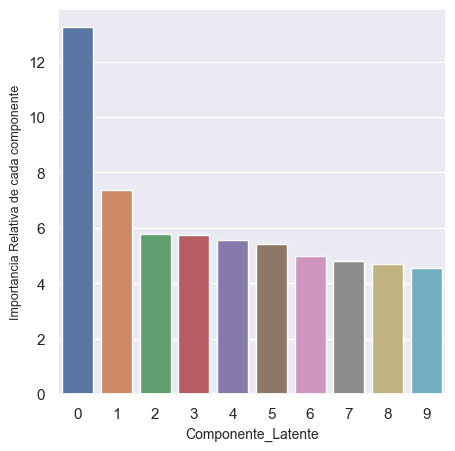

In [31]:
sns.set(rc={'figure.figsize':(5,5)}) 
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma )
chart.set_xlabel('Componente_Latente', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada componente', fontdict={'size': 9})
plt.show()

#**Pregunta - 5:**

Obtener la matriz tokens-temas (term-topic) a partir de la matriz ùëâÙÄØç de la descomposici√≥n SVD. Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [32]:
# La matriz V-transpuesta es la que genera la relaci√≥n Terms(word)-Topics,
# los renglones son los t√©rminos/words y las columnas los t√≥picos/temas:

lsi_term_topic = V_T 

print(lsi_term_topic.shape)

(96792, 10)


In [33]:
# rescatemos los nombres de los t√©rminos/tokens:

term_names = list(tfidf.get_feature_names_out())

print(term_names)

['aaa', 'aardman', 'aaron', 'aarron', 'aarts', 'aar√≥n', 'abad', 'abades', 'abadeses', 'abadi', 'abadi√±o', 'abad√≠a', 'abaitua', 'abajo', 'abal', 'abalanza', 'abalanzamos', 'abalanzaron', 'abalanz√°ndose', 'abalanz√≥', 'abalos', 'abalosmeco', 'abanca', 'abandera', 'abanderaban', 'abanderada', 'abanderadas', 'abanderado', 'abanderados', 'abanderando', 'abanderar', 'abandere', 'abanderen', 'abander√°ndose', 'abander√≥', 'abandoibarra', 'abandona', 'abandonaba', 'abandonaban', 'abandonada', 'abandonadas', 'abandonado', 'abandonados', 'abandonament', 'abandonamos', 'abandonan', 'abandonando', 'abandonar', 'abandonara', 'abandonaran', 'abandonaremos', 'abandonarla', 'abandonarle', 'abandonarlo', 'abandonarlos', 'abandonaron', 'abandonarse', 'abandonar√°', 'abandonar√°n', 'abandonar√≠a', 'abandonar√≠amos', 'abandonase', 'abandonasen', 'abandonats', 'abandone', 'abandonei', 'abandonemos', 'abandonen', 'abandones', 'abandono', 'abandonos', 'abandon√°ndolo', 'abandon√°ndose', 'abandon√©', 'aba

In [34]:
# Y generamos un DataFrame con la matriz term-topic:

term_topic_matrix = pd.DataFrame(data=lsi_term_topic, 
                                 index = term_names,   
                                 columns = [f'Concepto_Latente_{r}' for r in range(0,V_T.shape[1])]
                                )

print(term_topic_matrix.shape)   #  words X topics

(96792, 10)


In [35]:
term_topic_matrix.head(5)

Concepto_Latente_0  Concepto_Latente_1  Concepto_Latente_2  \
aaa                0.000029            0.000008           -0.000003   
aardman            0.000236           -0.000193           -0.000225   
aaron              0.000111           -0.000173           -0.000074   
aarron             0.000015           -0.000020           -0.000020   
aarts              0.000043           -0.000009           -0.000031   

         Concepto_Latente_3  Concepto_Latente_4  Concepto_Latente_5  \
aaa               -0.000065            0.000050            0.000011   
aardman           -0.000522            0.000542            0.000653   
aaron             -0.000141            0.000224            0.000406   
aarron            -0.000048            0.000061            0.000079   
aarts             -0.000071            0.000047            0.000085   

         Concepto_Latente_6  Concepto_Latente_7  Concepto_Latente_8  \
aaa               -0.000097        6.346538e-07            0.000028   
aardman           -0.000353       -1.668936e-05            0.000596   
aaron             -0.000435       -1.514414e-04            0.000134   
aarron            -0.000077       -1.618414e-06            0.000044   
aarts             -0.000038       -2.962197e-05           -0.000049   

         Concepto_Latente_9  
aaa               -0.000029  
aardman           -0.000220  
aaron             -0.000112  
aarron            -0.000057  
aarts             -0.000037

#**Pregunta - 6:**

Con base a la cantidad de conceptos latentes que determinaste en el ejercicio anterior, obtener cada uno de sus gr√°ficos con sus 10 t√©rminos/tokens m√°s importantes.

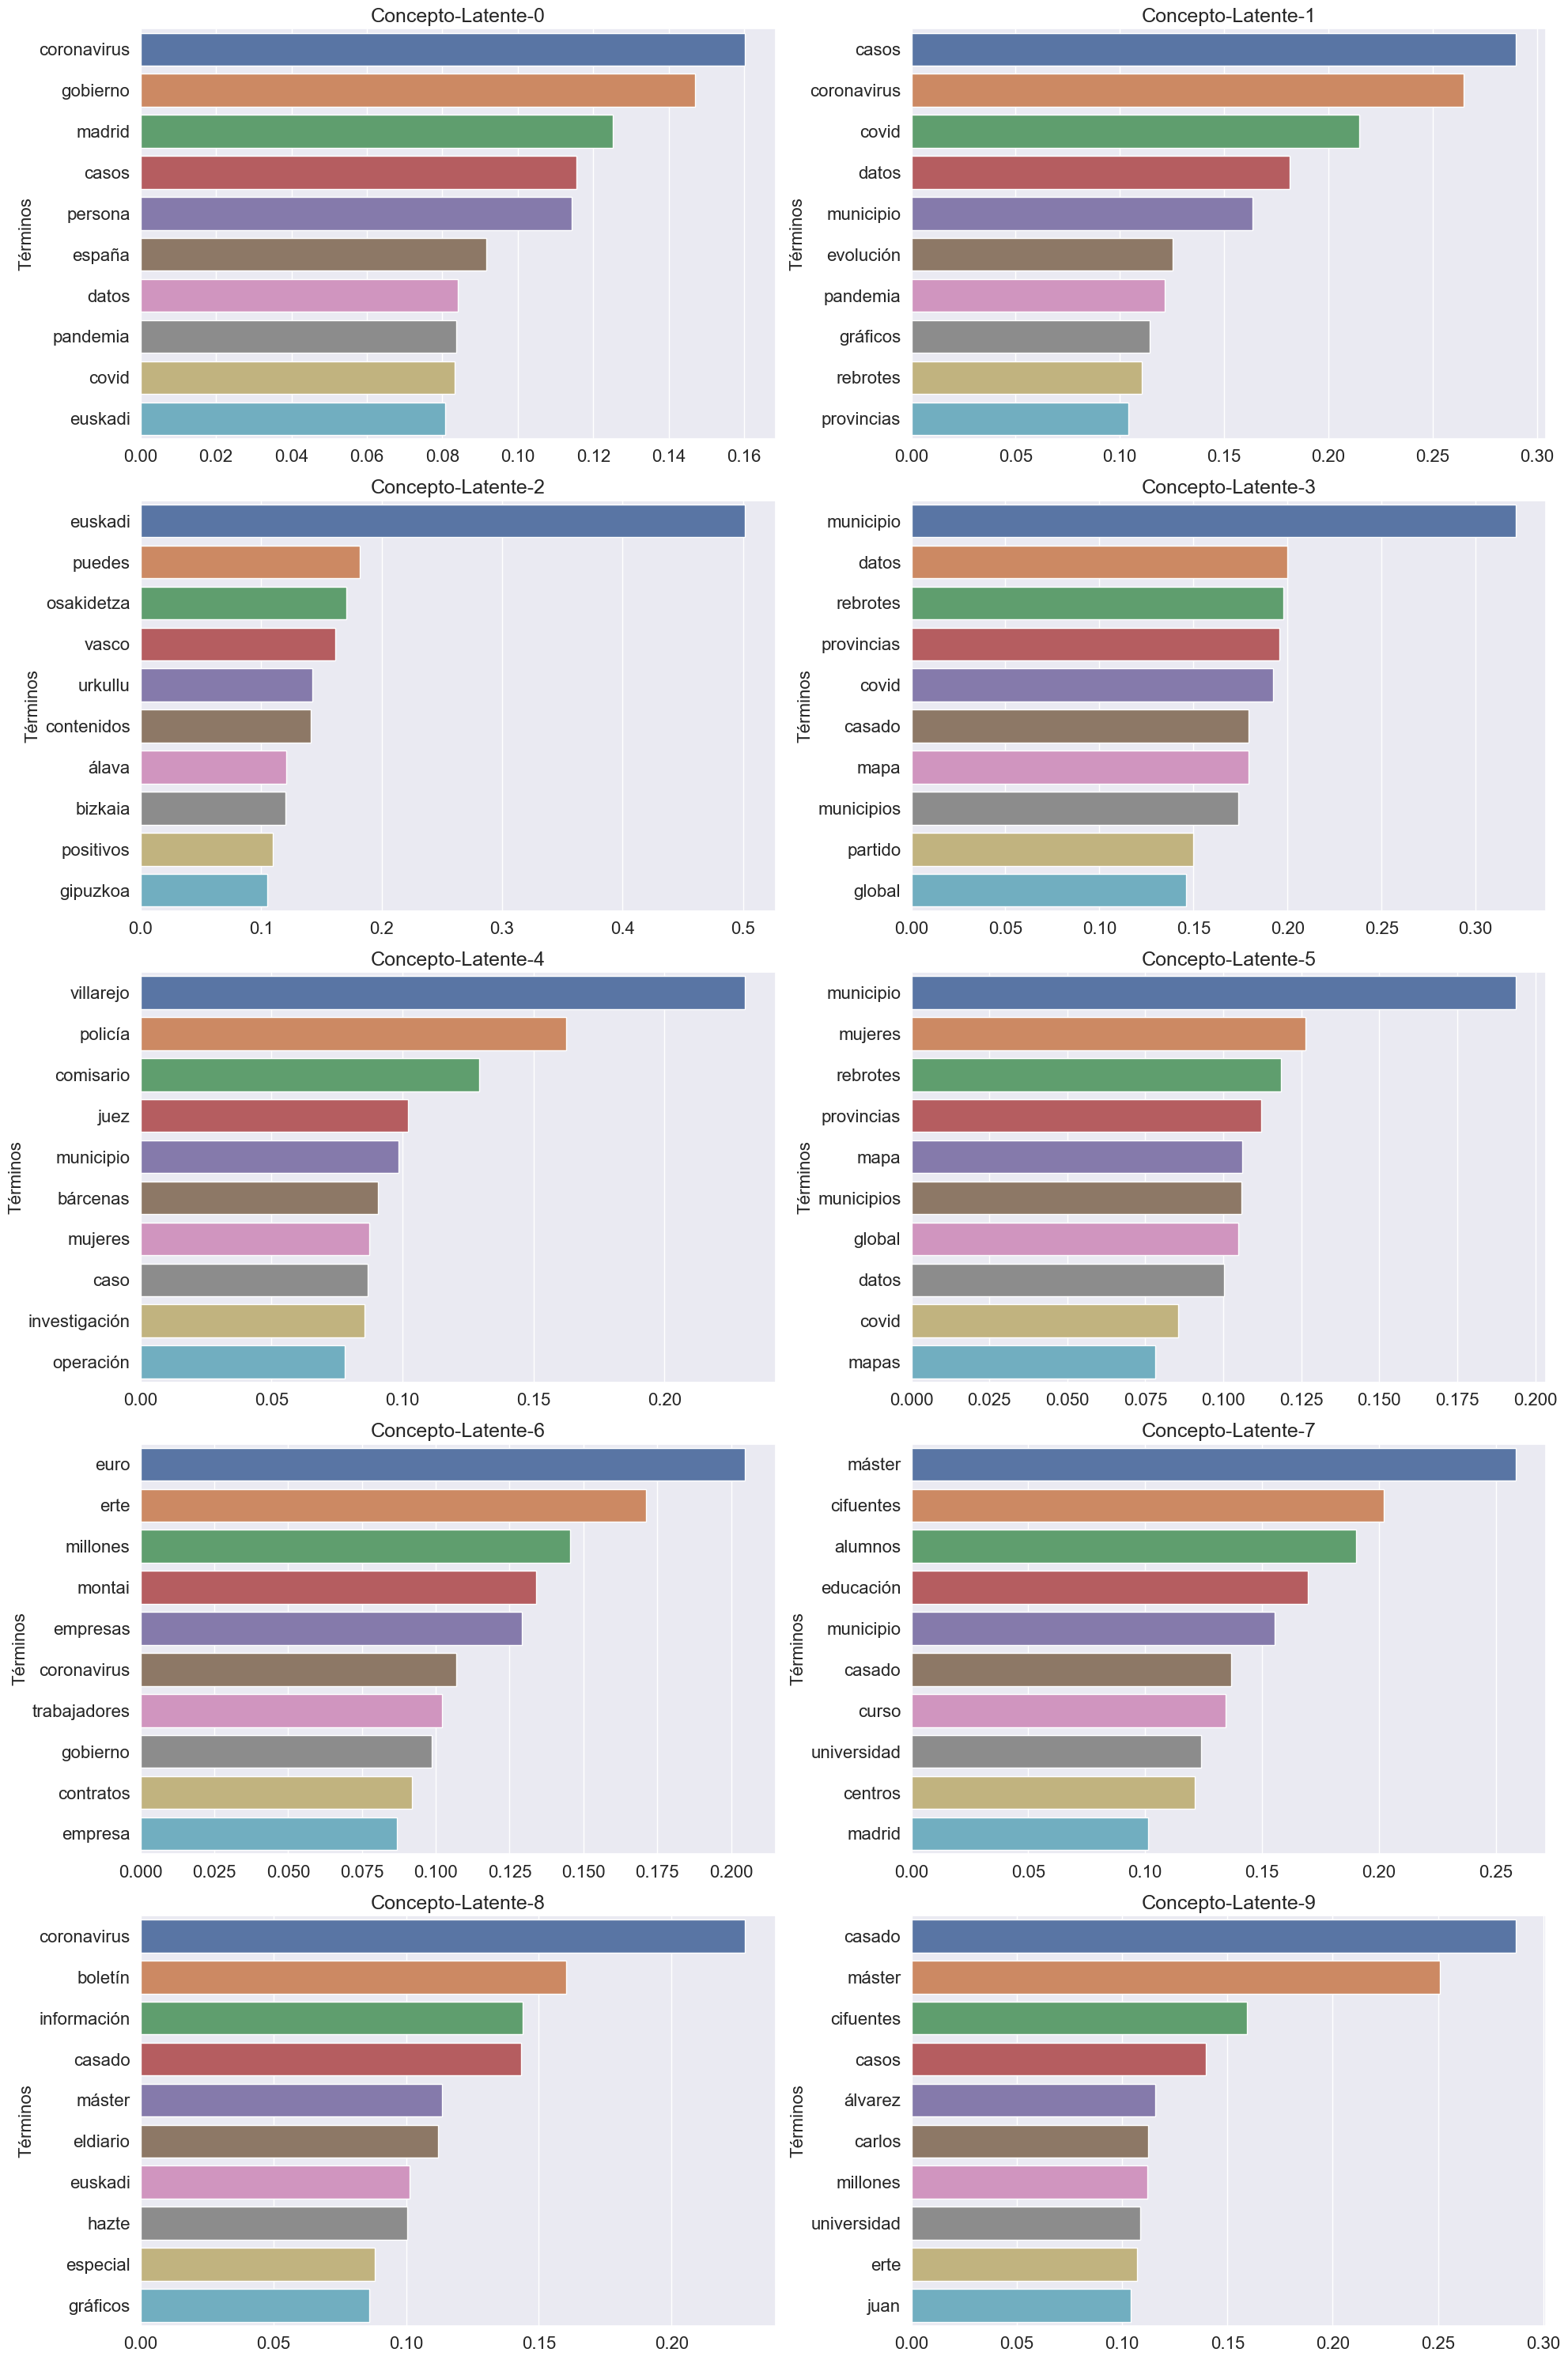

In [63]:
top_w = 10 

fig, axes = plt.subplots(5,2, figsize=(20, 30))
axes = axes.flatten()

for i in range(0,len(term_topic_matrix.columns)):
    data = term_topic_matrix[f'Concepto_Latente_{i}']
    data = data.sort_values(ascending=False)
    top_w_matrix = data[:top_w]
    
    # Creamos el histograma en el subplot correspondiente
    sns.barplot(ax=axes[i], x=top_w_matrix.values, y=top_w_matrix.index)
    axes[i].set_title(f'Concepto-Latente-{i}', fontsize=18)
    axes[i].set_ylabel('T√©rminos', fontsize=16)
    axes[i].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

#### ¬øC√≥mo describir√≠as cada uno de dichos conceptos latentes?

Referente a los conceptos latentes, me parece un proceso interesante para realizar la separaci√≥n y an√°lisis de un tema, como podemos ver el cada unos de los histogr√°mas tenemos un vistazo general de cada palabra que tiene un peso significativo en cada uno de nuestros documentos.

#### ¬øSe identifican claramente las tem√°ticas de cada uno de ellos?

En general se logra identificar de buena forma la tem√°tica en cada concepto latente, en el caso 2 hay algunas palabr√°s no identificadas, pero podr√≠amos tomarlas para poder hacer un filtrado m√°s profundo y obtener palabras que si permitan identificar de buena forma cada uno de los temas.

## Parte 2: Asignaci√≥n de Dirichlet Latente (LDA)

#**Pregunta - 7:**

Utiliza la librer√≠a Gensim para implementar ahora la t√©cnica de LDA. Revisa la documentaci√≥n correspondiente y aplica de preferencia el modelo paralelizable:
https://radimrehurek.com/gensim/models/ldamodel.html

https://radimrehurek.com/gensim/models/ldamulticore.html

In [50]:
# Crear el diccionario y el corpus
id2word = corpora.Dictionary(Xclean)
texts = Xclean
corpus = [id2word.doc2bow(text) for text in texts]

#**Pregunta - 8:**

Con base a esta t√©cnica ¬øqu√© cantidad de t√≥picos consideras que es la m√°s adecuada? Compara tus resultados con el m√©todo LSI. ¬øQu√© encuentras de coincidencias y diferencias? ¬øCu√°l consideras puede ser el mejor resultado, es decir, cu√°l consideras puede ser la mejor cantidad de t√≥picos a considerar?

In [56]:
# Crear el modelo LDA
num_topics = 10
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=10,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

In [57]:
# Mostrar los t√≥picos
for idx, topic in lda_model.print_topics(-1):
    print(f'T√≥pico: {idx}\nPalabras: {topic}\n')

T√≥pico: 0
Palabras: 0.017*"casos" + 0.017*"coronavirus" + 0.015*"cada" + 0.012*"d√≠as" + 0.012*"datos" + 0.012*"eldiario" + 0.012*"espa√±a" + 0.011*"informaci√≥n" + 0.009*"crisis" + 0.009*"mundo"

T√≥pico: 1
Palabras: 0.017*"caso" + 0.010*"polic√≠a" + 0.010*"investigaci√≥n" + 0.009*"juan" + 0.009*"tribunal" + 0.008*"seg√∫n" + 0.008*"carlos" + 0.007*"fiscal√≠a" + 0.007*"justicia" + 0.007*"juez"

T√≥pico: 2
Palabras: 0.018*"persona" + 0.014*"covid" + 0.014*"madrid" + 0.012*"comunidad" + 0.012*"medidas" + 0.012*"salud" + 0.010*"sanidad" + 0.010*"centros" + 0.009*"pandemia" + 0.009*"zona"

T√≥pico: 3
Palabras: 0.024*"gobierno" + 0.011*"podemos" + 0.009*"partido" + 0.009*"pol√≠tica" + 0.009*"madrid" + 0.007*"presidente" + 0.007*"s√°nchez" + 0.006*"ciudadanos" + 0.006*"casado" + 0.005*"psoe"

T√≥pico: 4
Palabras: 0.013*"millones" + 0.009*"euro" + 0.007*"empresas" + 0.007*"trabajo" + 0.006*"social" + 0.005*"empresa" + 0.005*"seg√∫n" + 0.004*"mayor" + 0.004*"trabajadores" + 0.004*"econom√≠a"


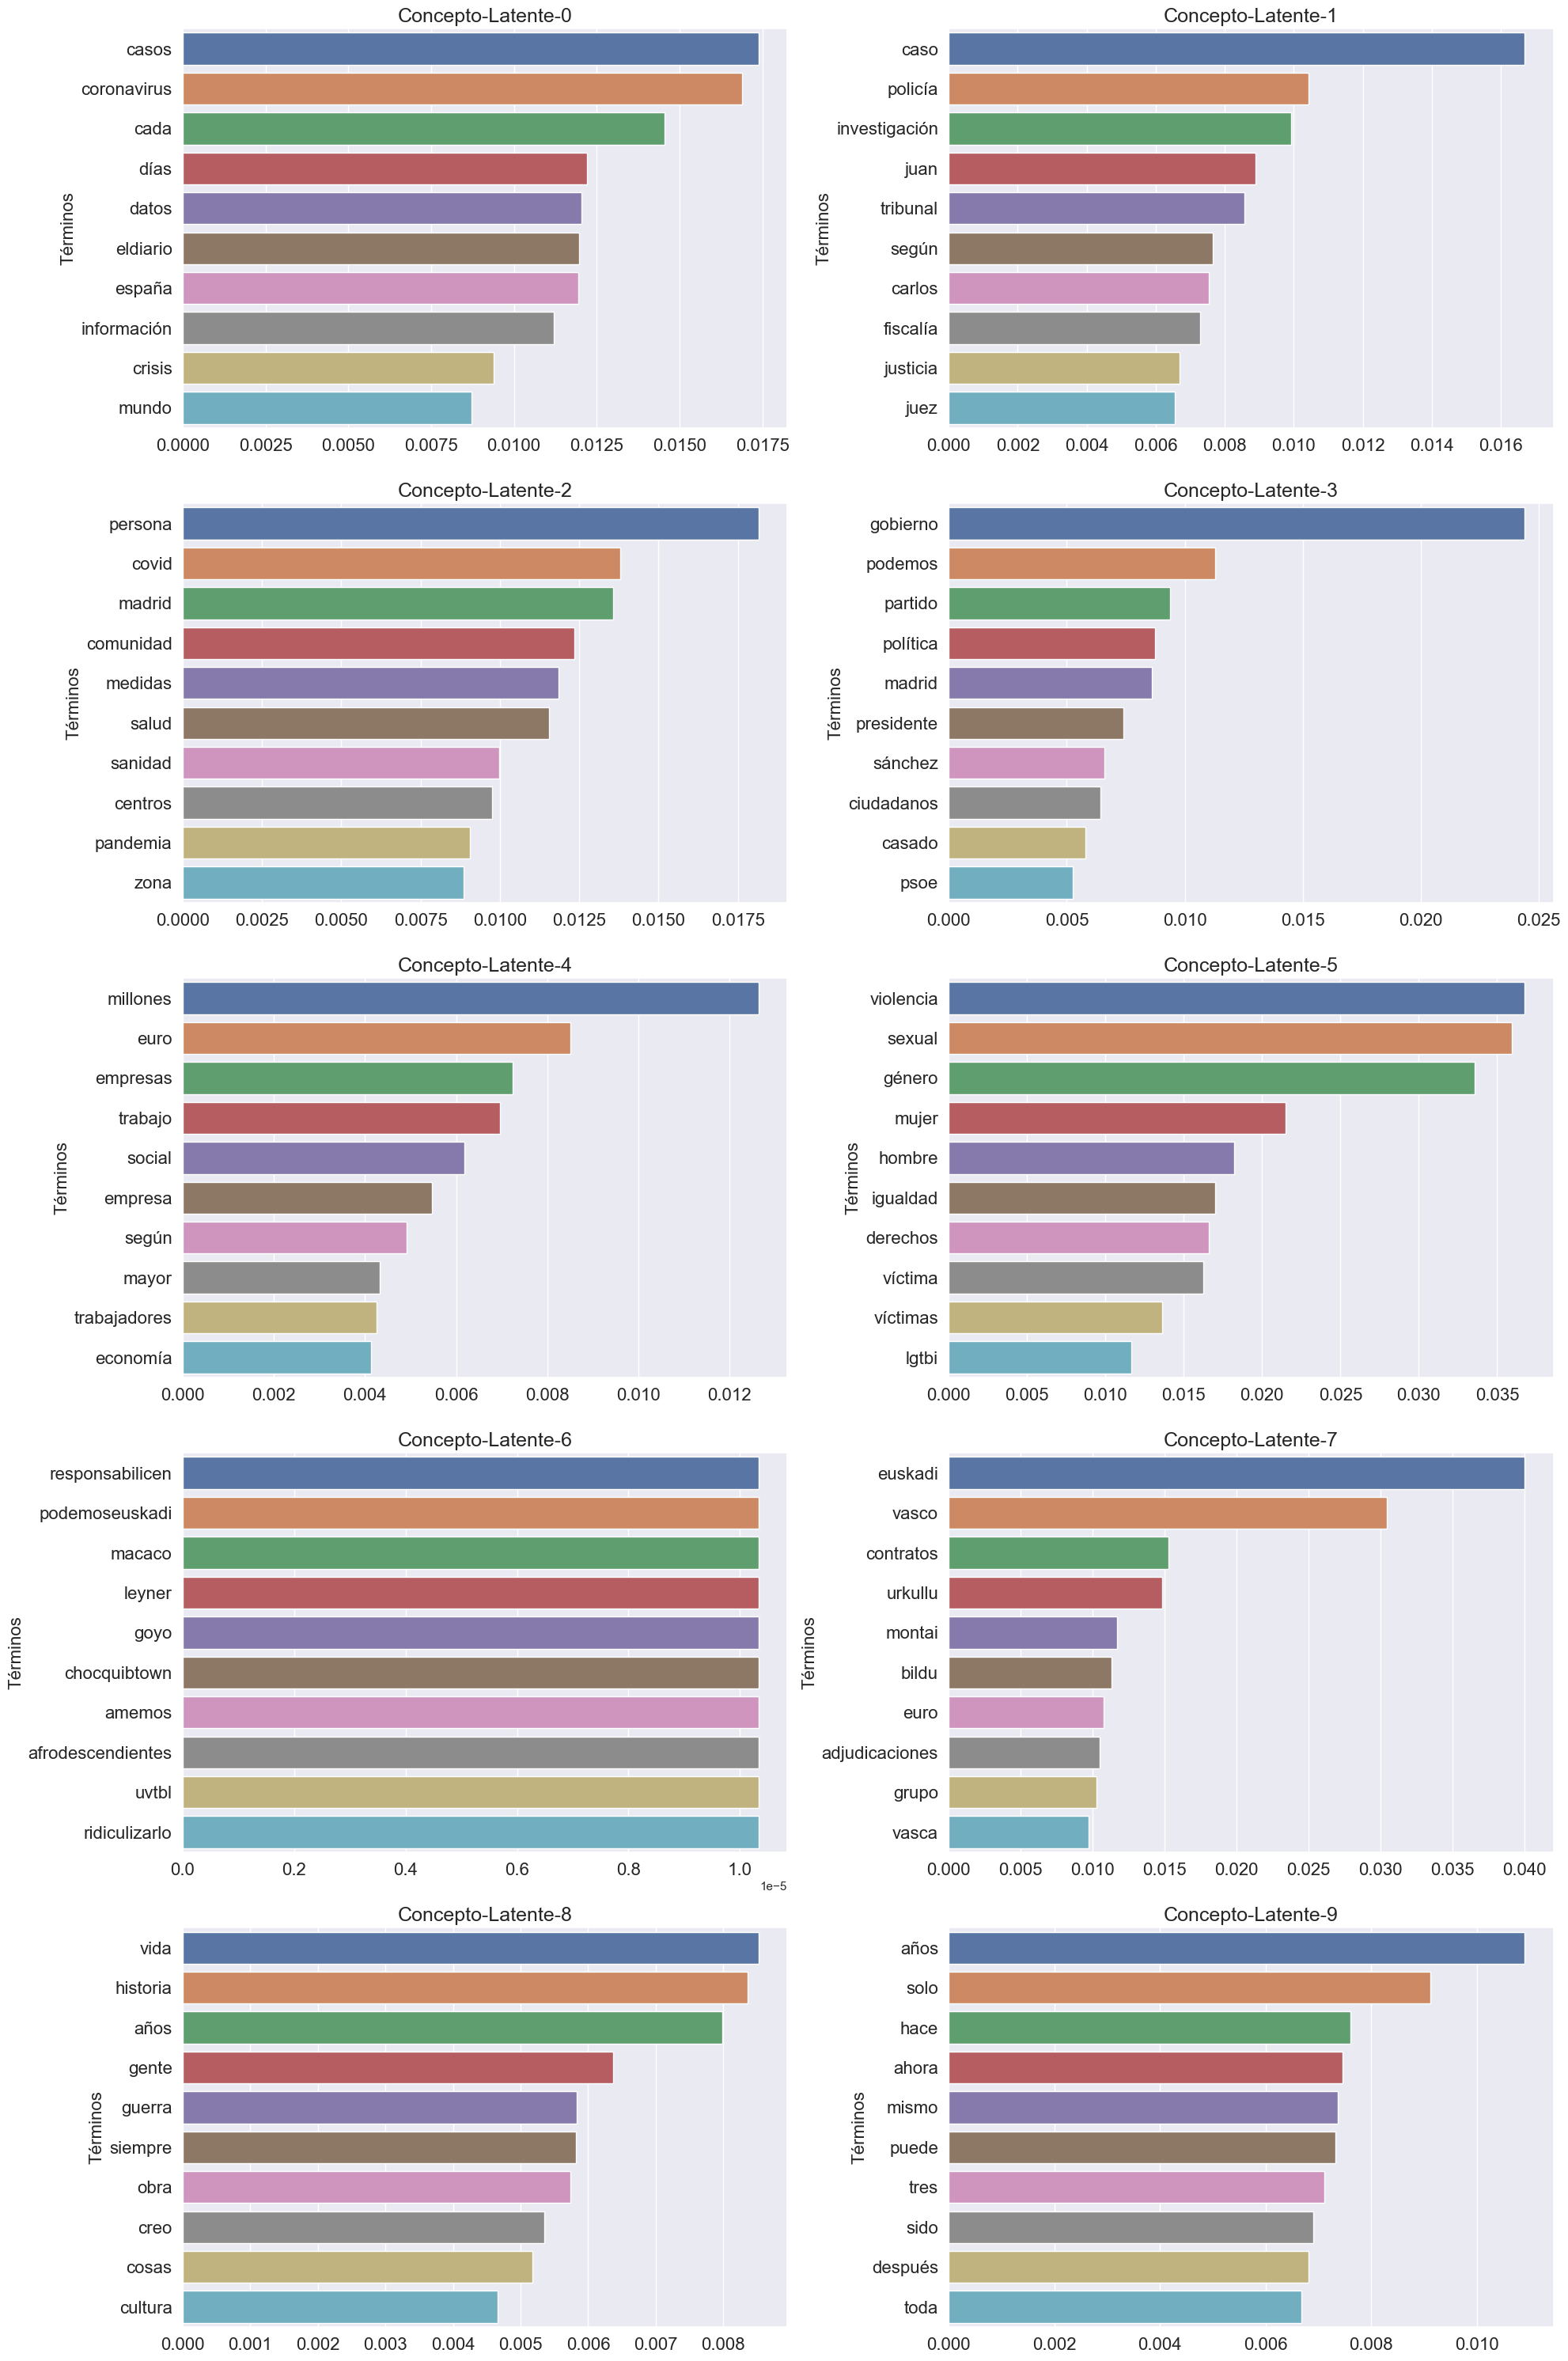

In [64]:
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(5,2, figsize=(20, 30))
axes = axes.flatten()

for i in range(num_topics):
    topic_terms = lda_model.show_topic(i, topn=10)
    terms = [term for term, _ in topic_terms]
    weights = [weight for _, weight in topic_terms]
    
    # Creamos el histograma en el subplot correspondiente
    sns.barplot(ax=axes[i], x=weights, y=terms)
    axes[i].set_title(f'Concepto-Latente-{i}', fontsize=18)
    axes[i].set_ylabel('T√©rminos', fontsize=16)
    axes[i].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

#### ¬øQu√© cantidad de t√≥picos consideras que es la m√°s adecuada?

Dada la cantidad de informaci√≥n presentada por el corpus, me parece buena la cantidad de 10 topicos, aunque podr√≠a ser m√°s elevada para poder obtener un buen an√°lisis y representaci√≥n de cada uno de los topicos. En general puedo visualizar que algunos se concentran en el tema de la pandemia as√≠ como algunos otros t√©mas sociales.

#### ¬øQu√© encuentras de coincidencias y diferencias?

En general hay algunos temas en com√∫n, tal es el caso de la pandemia, sin embargo puedo ver que la variedad es mayor a trav√©s del an√°lisis con el proceso LDA, as√≠ mismo, al momento de realizar el procesamiento es considerablemente m√°s laborioso y tardado que el procesamiento con Factorizaci√≥n SVD.

#### ¬øCu√°l consideras puede ser el mejor resultado, es decir, cu√°l consideras puede ser la mejor cantidad de t√≥picos a considerar?

Para obtener mejores resultados me parece el m√©todo LDA se puede obtener mejores resultados aunque el poder de c√≥mputo suele ser mayor.

#**Pregunta - 9:**

#### Incluye tus comentarios finales de la actividad.



En esta pr√°ctica, exploramos dos t√©cnicas fundamentales para el an√°lisis de t√≥picos en conjuntos de datos de texto: Latent Dirichlet Allocation (LDA) y Singular Value Decomposition (SVD). Ambas t√©cnicas son ampliamente utilizadas en el procesamiento de lenguaje natural y la miner√≠a de textos para descubrir la estructura subyacente en grandes vol√∫menes de documentos.

En nuestra pr√°ctica, aplicamos LDA a nuestro conjunto de datos y observamos c√≥mo los documentos se distribuyen en diferentes t√≥picos. Esto nos permiti√≥ obtener una comprensi√≥n m√°s profunda de los temas presentes en el corpus y c√≥mo est√°n relacionados entre s√≠.

En nuestra pr√°ctica, aplicamos SVD para reducir la dimensionalidad de la matriz TF-IDF generada a partir de nuestro conjunto de datos. Esto nos permiti√≥ visualizar la distribuci√≥n de documentos en un espacio de menor dimensi√≥n y examinar las relaciones entre los documentos y los t√≥picos identificados por LDA.

En resumen, mediante el uso de LDA y SVD, pudimos explorar la estructura latente en nuestros datos de texto y descubrir los t√≥picos principales presentes en el corpus. Estas t√©cnicas son √∫tiles para una variedad de aplicaciones, como la agrupaci√≥n de documentos, la recomendaci√≥n de contenido y el an√°lisis de sentimientos, y pueden proporcionar informaci√≥n valiosa para la toma de decisiones en una amplia gama de campos.